In [1]:
    import requests
    from bs4 import BeautifulSoup

    base_url = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=136900&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=newest&page={}"
    reviews = []
    for n in range(5000):
        url = base_url.format(n+1)
        resp = requests.get(url)
        html = BeautifulSoup(resp.content, 'html.parser')

        score_result = html.find('div', {'class': 'score_result'})
        score_result2 = html.find('div', {'class': 'star_score'})
    
    
        lis = score_result.findAll('li')
    
        for li in lis :
            review_text = li.find('p').getText()
            star = score_result2.getText()
            comment = review_text.strip().replace("\t","").replace("\n","").replace("\r","")
            star = int(star)
            label = 0 if star < 5 else 1
            reviews.append([label, comment])
    train_data = [[], []]    
    for review in reviews:
        label = review[0]
        comment = review[1]
        
        train_data[0].append(label)
        train_data[1].append(comment)


In [2]:
len(train_data[1])

50000

In [3]:
    import requests
    from bs4 import BeautifulSoup

    base_url = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=136900&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=newest&page={}"
    reviews = []
    for n in range(5001,6001):
        url = base_url.format(n+1)
        resp = requests.get(url)
        html = BeautifulSoup(resp.content, 'html.parser')

        score_result = html.find('div', {'class': 'score_result'})
        score_result2 = html.find('div', {'class': 'star_score'})
    
    
        lis = score_result.findAll('li')
    
        for li in lis :
            review_text = li.find('p').getText()
            star = score_result2.getText()
            comment = review_text.strip().replace("\t","").replace("\n","").replace("\r","")
            star = int(star)
            label = 0 if star < 5 else 1
            reviews.append([label, comment])
    test_data = [[], []]    
    for review in reviews:
        label = review[0]
        comment = review[1]
        
        test_data[0].append(label)
        test_data[1].append(comment)


In [4]:
len(test_data[1])

10000

In [2]:
from konlpy.tag import Okt
import json
import os
from pprint import pprint

okt = Okt()

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json', encoding ='UTF-8') as f:
        train_docs = json.load(f)
    with open('test_docs.json',encoding='UTF-8') as f:
        test_docs = json.load(f)
else:
    train_docs = []
    test_docs = []
    for i in range(0,len(train_data[0])):
        train_docs.append([tokenize(train_data[1][i]), train_data[0][i]])
    for i in range(0,len(test_data[0])):
        test_docs.append([tokenize(test_data[1][i]), test_data[0][i]])
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

In [3]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

542849


In [4]:
import nltk
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

542849
16663
[('관람객/Noun', 24950), ('./Punctuation', 13484), ('하다/Verb', 12621), ('보다/Verb', 12327), ('영화/Noun', 10192), ('이/Josa', 8748), ('마블/Noun', 7604), ('의/Josa', 6385), ('.../Punctuation', 5716), ('../Punctuation', 5535)]


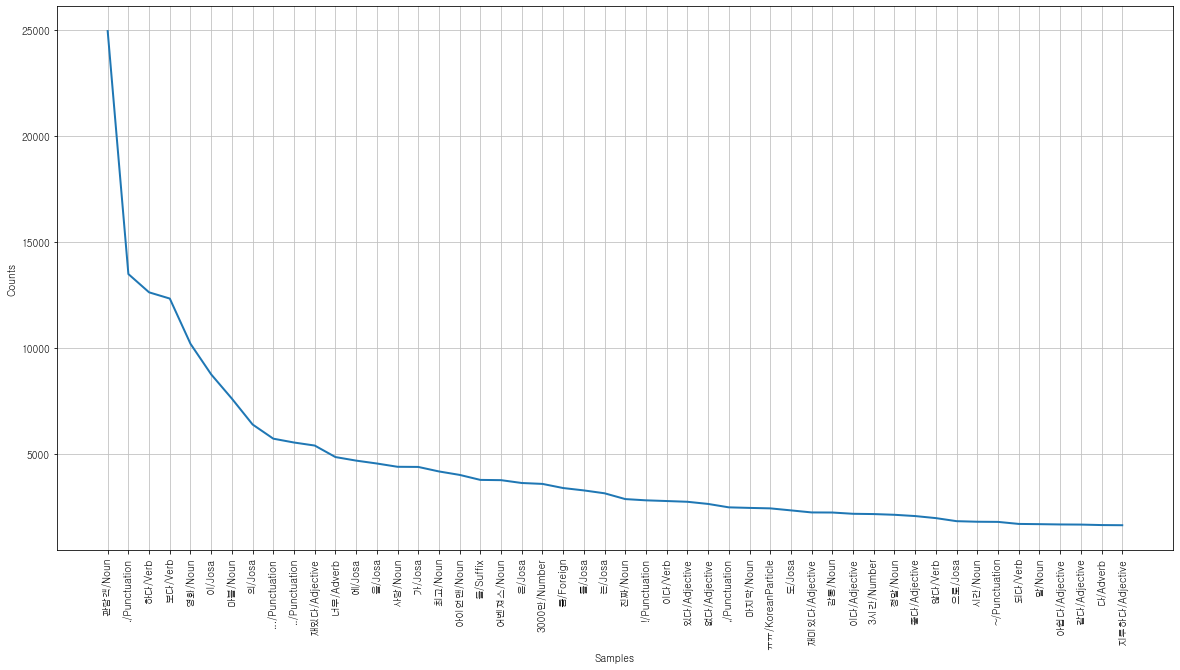

In [5]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [6]:
selected_words = [f[0] for f in text.vocab().most_common(3000)]
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [7]:
#모델링을 하기 위해 리스트로 되어 있는 데이터 형식을 array로 바꿔주고 dtype도 실수로 바꿈
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics


# 모델 구조 정의하기
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(3000,))) #3000개로 Vectorizati6on 해주었기 때문에 input_shape 3000으로 입력
model.add(layers.Dense(64, activation='relu')) #ReLU 활성화함수 채택
model.add(layers.Dense(1, activation='sigmoid'))
#분류(classification)을 위해 softmax 함수 사용 실수를 확률의 값(0~1사이)

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512) #512개에 한 번씩 업데이터 실행
results = model.evaluate(x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
50000/50000 [==============================] - 3s 63us/sample - loss: 0.2367 - binary_accuracy: 0.9576
Epoch 2/10
50000/50000 [==============================] - 2s 43us/sample - loss: 0.1721 - binary_accuracy: 0.96080s - loss: 0.1716 - binary_accurac
Epoch 3/10
50000/50000 [==============================] - 2s 43us/sample - loss: 0.1649 - binary_accuracy: 0.9608
Epoch 4/10
50000/50000 [==============================] - 2s 45us/sample - loss: 0.1616 - binary_accuracy: 0.9608
Epoch 5/10
50000/50000 [==============================] - 2s 45us/sample - loss: 0.1596 - binary_accuracy: 0.9608
Epoch 6/10
50000/50000 [==============================] - 2s 45us/sample - loss: 0.1579 - binary_accuracy: 0.9608
Epoch 7/10
50000/50000 [==============================] - 2s 44us/samp

In [9]:
results #

[0.1273702267050743, 0.9748]

In [10]:
def predict_pos_neg(review):
    token = tokenize(review) #토큰화
    tf = term_frequency(token) #토큰화된 단어를 이용해서 가장 많이 등장하는 단어와의 빈도수 체크
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data)) #새로운 데이터를 받으면 결과 예측
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [11]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")
predict_pos_neg("다신 안볼꺼야")

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 98.86% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 94.61% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 99.15% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[믿고 보는 감독이지만 이번에는 아니네요]는 95.79% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[주연배우 때문에 봤어요]는 96.75% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[다신 안볼꺼야]는 94.04% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

